In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define seed
np.random.seed(0)

# System parameters
g, tP, Cv, rho = 9.8, -0.5, 30.875, 1020
tH0, tH1, tH2 = 3.51e-5, 3.29e-4, -0.01

# Simulation parameters
dt, n, r = 0.1, 4, 4
timesteps = 250
t = np.arange(timesteps) * dt
alpha, beta = 0.1, 0.7
delta, eps, lam = 0.999, 0.999, 0.999

# Simulation matrices
C = np.eye(4)

In [ ]:
# Noise model
def noise():
    return np.random.normal([-0.2, -0.2, -0.2, -5 / 3600], [0.2, 0.2, 0.2, 5 / 3600])

In [ ]:
# Pump model (Oliveira, 2023)
def pump_mod(x, u):
    # Head pump
    H = tH0 * u + tH1 * (x[3] / 3600) * u + tH2 * (x[3] / 3600) ** 2

    # System dynamic
    p1 = x[0] + tP * dt
    p2 = p1 + rho * g * H * 1e-5
    p3 = x[2] + tP * dt
    q = (Cv / 3600) * np.sqrt((p2 * 1e5 - p3 * 1e5) / rho)

    return np.array([p1, p2, p3, q])

# R. D. Oliveira, H. A. Krog, G. A. Le Roux, and J. J¨aschke, “Sensor bias detection, isolation, and estimation in a subsea pump system.” in 33rd European Symposium on Computer Aided Process Engineering, ser. Computer Aided Chemical Engineering, A. C. Kokossis, M. C. Georgiadis, and E. Pistikopoulos, Eds. Elsevier, 2023, vol. 52, pp. 1725–1730.

In [ ]:
# Extended kalman filter
def ekf(y, x, theta, Phik, lambda_, Pk, Qk, Rk, Sk, Upsilon, u, mode='static'):
    # Nonlinear approximation
    if mode == 'static' or mode == 'jacobian':
        droot = 2 * rho * np.sqrt((x[1] - x[2]) * 1e5 / rho)
        F = np.array([
            [1, 0, 0, 0], [1, 0, 0, rho * g * (tH1 * tH1 / 3600 + 2 * tH2 * x[3] / (3600 ** 2)) * 1e-5],
             [0, 0, 1, 0], [0, (Cv / 3600) / droot, -(Cv / 3600) / droot, 0]])
    elif mode == 'holt':
        F = alpha * (1 + beta) * np.eye(4)

    # Prediction stage
    Pk = F @ Pk @ F.T + Qk
    Sigma = C @ Pk @ C.T + Rk
    Kk = Pk @ C.T @ np.linalg.inv(Sigma)
    Pk = (np.eye(n) - Kk @ C) @ Pk

    # Update stage
    Omega = C @ F @ Upsilon + C @ Phik
    Upsilon = (np.eye(n) - Kk @ C) @ F @ Upsilon + (np.eye(n) - Kk @ C) @ Phik
    Lambda = np.linalg.inv(lambda_ * Sigma + Omega @ Sk @ Omega.T)
    Gamma = Sk @ Omega.T @ Lambda
    Sk = (1/lambda_) * Sk - (1/lambda_) * Sk @ Omega.T @ Lambda @ Omega @ S

    # Innovation
    ytilde = y - C @ (pump_mod(x, u) + Phi @ theta * dt)

    # Parameter adjustment
    if mode == 'jacobian' or mode == 'holt':
        # Noise covariance
        Xi = Kk + Upsilon @ Gamma
        Qk = delta * Qk + (1 - delta) * (Xi @ ytilde.reshape(4,1) @ \
                                 ytilde.reshape(4,1).T @ Xi.T)
        # Rk = eps * Rk + (1 - eps) * (ytilde @ ytilde.T + C @ Pk @ C.T) # Residual approach
        Rk = eps * Rk + (1 - eps) * ((np.eye(4) - C @ Xi) @ ytilde.reshape(4,1) @ \
                                     ytilde.reshape(4,1).T @ (np.eye(4) - C @ Xi).T)

        # Fault profile
        Phest = np.linalg.inv(C @ F @ (np.eye(4) - Kk @ C) + C) \
                @ (Omega - C @ F @ (np.eye(4) - Kk @ C) @ F @ Upsilon) # Could be non-invertible
        Omest = C @ F @ Upsilon + C @ Phest
        gamma = np.matrix.trace(Omest @ Sk @ Omest.T) / np.matrix.trace(Omega @ Sk @ Omega.T)
        Phik = Phik * np.sqrt(gamma)

    # Estimation
    theta += Gamma @ ytilde
    x = pump_mod(x, u) + Phik @ theta * dt + Kk @ ytilde + Upsilon @ Gamma @ ytilde

    return x, theta, Pk, Qk, Rk, Sk, Upsilon, Phik

In [ ]:
# Initialize states and estimation variables
xact = np.array([201.7, 202, 200, (458.3/3600)])
thetaact, yact = np.zeros(r), xact.copy()
xhat, xjac, xhol = xact.copy(), xact.copy(), xact.copy()
thetahat, thetajac, thetahol = np.zeros(r), np.zeros(r), np.zeros(r)

# Preallocate storage arrays
xactArray = np.zeros((timesteps, n))
thetaactArray, yactArray = np.zeros((timesteps, r)), np.zeros((timesteps, n))
xhatArray, xjacArray, xholArray = np.zeros((timesteps, n)), np.zeros((timesteps, n)), np.zeros((timesteps, n))
thetahatArray, thetajacArray, thetaholArray = np.zeros((timesteps, r)), np.zeros((timesteps, r)), np.zeros((timesteps, r))
xehatArray, xejacArray, xeholArray = xactArray.copy(), xactArray.copy(), xactArray.copy()
tehatArray, tejacArray, teholArray = thetaactArray.copy(), thetaactArray.copy(), thetaactArray.copy()

# Fault profile
Phi, Phijac, Phihol = np.eye(4), np.eye(4), np.eye(4)

# Filter parameters
Q, R = 0.001 * np.eye(n), 0.1 * np.eye(n)
P, S, Ups = 0.01 * np.eye(n), 50 * np.eye(r), np.zeros((n, r))
Qjac, Rjac = 0.001 * np.eye(n), 0.1 * np.eye(n)
Pjac, Sjac, Upsjac = 0.01*np.eye(n), 50*np.eye(r), np.zeros((n, r))
Qhol, Rhol = 0.001 * np.eye(n), 0.1 * np.eye(n)
Phol, Shol, Upshol = 0.01 * np.eye(n), 50 * np.eye(r), np.zeros((n, r))

# Main loop
for i in range(timesteps):
    # Fault injection
    thetaact = np.array([-5 if i >= 5 else 0, 0.2 * (i-5) if i >= 5 else 0, \
                         -7 if i >= 5 else 0, 0.5 if i >= 5 else 0])

    # Variable storage
    xactArray[i], yactArray[i], thetaactArray[i] = xact, yact, thetaact
    xhatArray[i], thetahatArray[i] = xhat, thetahat
    xjacArray[i], thetajacArray[i] = xjac, thetajac
    xholArray[i], thetaholArray[i] = xhol, thetahol

    # Dynamic calculation
    uact = 3500
    xact = pump_mod(xact, uact) + Phi @ thetaact * dt
    yact = xact + noise()

    # State and fault estimation
    xhat, thetahat, P, Q, R, S, Ups, Phi  = ekf(yact, xhat, thetahat, Phi, lam, \
                                                P, Q, R, S, Ups, uact, mode='static')
    xjac, thetajac, Pjac, Qjac, Rjac, Sjac, Upsjac, Phijac = ekf(yact, xjac, thetajac, Phijac, lam, \
                                                                 Pjac, Qjac, Rjac, Sjac, Upsjac, uact, mode='jacobian')
    xhol, thetahol, Phol, Qhol, Rhol, Shol, Upshol, Phihol = ekf(yact, xhol, thetahol, Phihol, lam, \
                                                                 Phol, Qhol, Rhol, Shol, Upshol, uact, mode='holt')

    # Estimation error
    xehatArray[i], xejacArray[i], xeholArray[i] = xact - xhat, xact - xjac, xact - xhol
    tehatArray[i], tejacArray[i], teholArray[i] = thetaact - thetahat, thetaact - thetajac, thetaact - thetahol

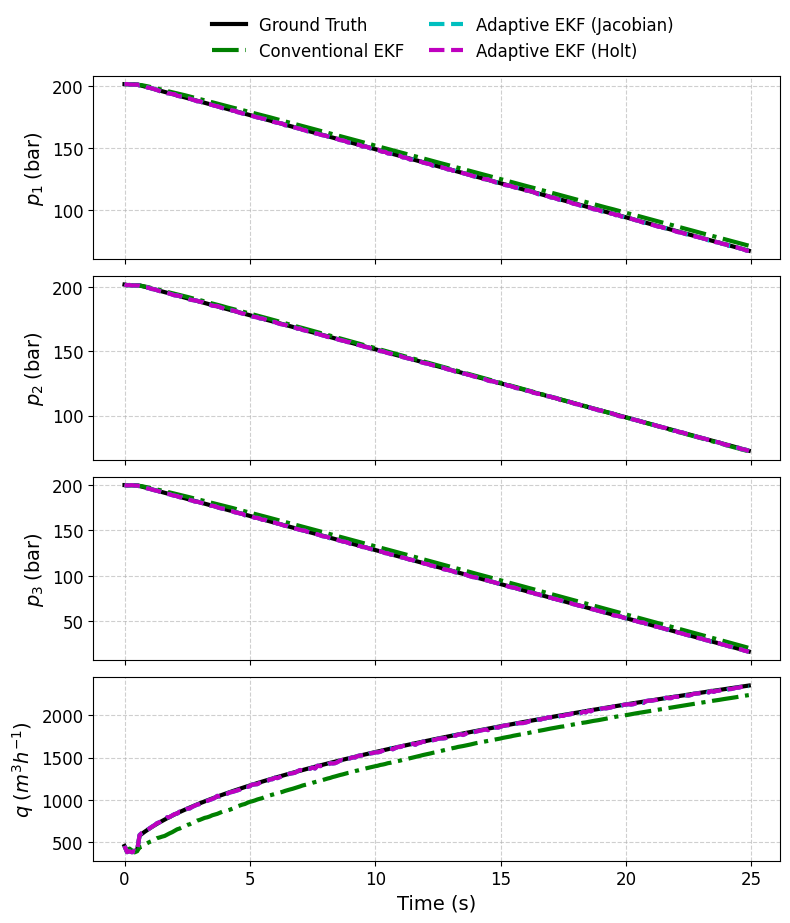

In [ ]:
# Plot actual vs estimated trajectory
fig, axes = plt.subplots(4, 1, figsize=(8, 10), sharex=True)

plot_styles = [
    ('k-', xactArray, 'Ground Truth'),
    ('g-.', xhatArray, 'Conventional EKF'),
    ('c--', xjacArray, 'Adaptive EKF (Jacobian)'),
    ('m--', xholArray, 'Adaptive EKF (Holt)')
]

y_labels = [r'$p_1\;$(bar)', r'$p_2\;$(bar)', r'$p_3\;$(bar)', r'$q\;$($m^3h^{-1}$)']

for i, ax in enumerate(axes):
    mult = 3600 if i == 3 else 1
    for style, data, label in plot_styles:
        ax.plot(t, mult * data[:, i], style, linewidth=3, label=label)

    ax.set_ylabel(y_labels[i], fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)

axes[-1].set_xlabel('Time (s)', fontsize=14)

lines, labels = [], []
for style, _, label in plot_styles:
    line, = axes[0].plot([], [], style, linewidth=3)
    lines.append(line)
    labels.append(label)
fig.legend(lines, labels, loc='upper center', ncol=2, fontsize=12, frameon=False, bbox_to_anchor=(0.56, 1.06), columnspacing=1.5)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

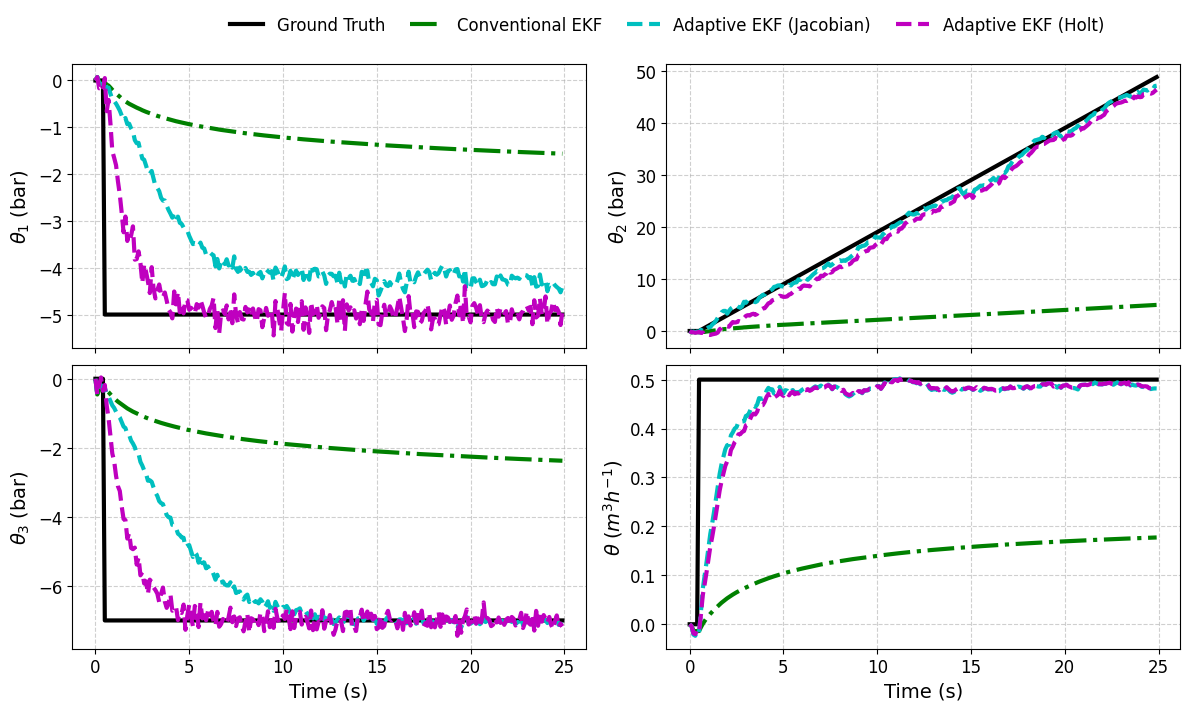

In [ ]:
# Plot parameter estimation results
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

plot_styles = [
    ('k-', thetaactArray, 'Ground Truth'),
    ('g-.', thetahatArray, 'Conventional EKF'),
    ('c--', thetajacArray, 'Adaptive EKF (Jacobian)'),
    ('m--', thetaholArray, 'Adaptive EKF (Holt)')
]

y_labels = [r'$\theta_1\;$(bar)', r'$\theta_2\;$(bar)', r'$\theta_3\;$(bar)', r'$\theta\;$($m^3h^{-1}$)']

for i, ax in enumerate(axes.flat):
    mult = 3600 if i == 3 else 1
    for style, data, label in plot_styles:
        ax.plot(t, data[:, i], style, linewidth=3, label=label)

    ax.set_ylabel(y_labels[i], fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)

for ax in axes[1]:
    ax.set_xlabel('Time (s)', fontsize=14)

lines, labels = [], []
for style, _, label in plot_styles:
    line, = axes[0, 0].plot([], [], style, linewidth=3)
    lines.append(line)
    labels.append(label)
fig.legend(lines, labels, loc='upper center', ncol=4, fontsize=12, frameon=False, bbox_to_anchor=(0.56, 1.06), columnspacing=1.5)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

In [ ]:
# State estimation RMSE
print(np.sqrt(np.mean(xehatArray ** 2, axis=0)))
print(np.sqrt(np.mean(xejacArray ** 2, axis=0)))
print(np.sqrt(np.mean(xeholArray ** 2, axis=0)))

# Fault estimation RMSE
print(np.sqrt(np.mean(tehatArray ** 2, axis=0)))
print(np.sqrt(np.mean(tejacArray ** 2, axis=0)))
print(np.sqrt(np.mean(teholArray ** 2, axis=0)))

[3.07725126 0.75653628 3.79313539 0.04332572]
[0.28970082 0.26341074 0.29197998 0.00218169]
[0.29953972 0.2589161  0.30093982 0.00214504]
[ 3.76852317 24.96644794  5.09332731  0.36168746]
[1.61556754 0.99431079 1.95018642 0.07772262]
[0.77129562 2.00514416 1.04892303 0.08471881]
